# Ubicación de las Fincas en el Espacio

In [ ]:
import pandas as pd
# Cargar Coordenadas y Producción
coord_df = pd.read_excel('Coordenadas.xlsx', sheet_name = 'Hoja1')
produccion = pd.read_excel('Produccion.xlsx', sheet_name = 'Hoja1')

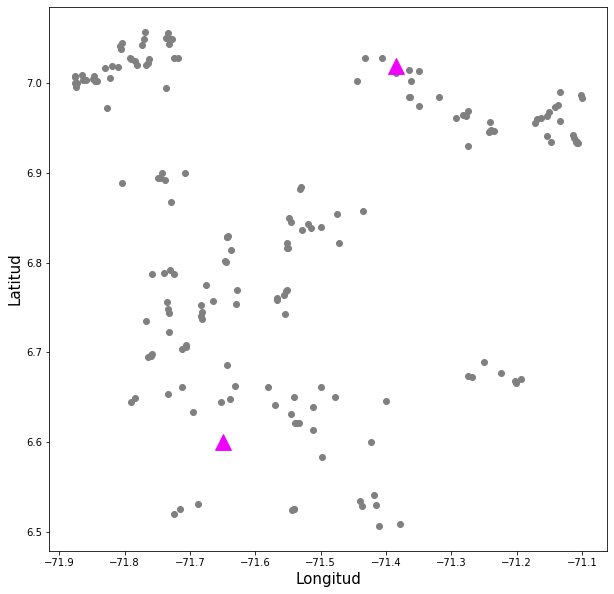

In [ ]:
import matplotlib.pyplot as plt

f = plt.figure()
f.set_figwidth(10)
f.set_figheight(10)
centrosIniciales = [(7.019472, -71.384889), (6.6, -71.65)]
plt.scatter(coord_df['Longitud'], coord_df['Latitud'], c ="gray")
plt.scatter(centrosIniciales[0][1], centrosIniciales[0][0], color = (240/255, 0/255, 255/255), marker = "^", s = 250)
plt.scatter(centrosIniciales[1][1], centrosIniciales[1][0], color = (240/255, 0/255, 255/255), marker = "^", s = 250)
plt.xlabel('Longitud', fontsize = 15)
plt.ylabel('Latitud', fontsize = 15)
plt.show()

# Asignación Fincas a Plantas Post Cosecha

## Implementación

In [ ]:
!python -m pip install -i https://pypi.gurobi.com gurobipy
!pip install haversine

Looking in indexes: https://pypi.gurobi.com, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from haversine import haversine
from gurobipy import*

# Cargar Datos
coord_df = pd.read_excel('Coordenadas.xlsx', sheet_name = 'Hoja1')
produccion = pd.read_excel('Produccion.xlsx', sheet_name = 'Hoja1')
ejeX = list(coord_df['Longitud'])
ejeY = list(coord_df['Latitud'])
u = []
for j in range(len(ejeX)):
  u.append((ejeY[j], ejeX[j])) # Ubicación de cada finca

# Definir los conjuntos
n = 180 # Número de fincas
m = 2 # Número de plantas postcosecha
F = [i for i in range(n)] # Fincas
P = [j for j in range(m)] # Plantas

# Definir los parámetros
# Distancia entre cada finca y cada planta post cosecha (km)
#centrosIniciales = [(6.9, -71.6), (6.75, -71.45)]
centrosIniciales = [(7.019472, -71.384889), (6.6, -71.65)]
contFinca = 0
d = {}
for fincaAct in u:
  contCentro = 0
  for centro in centrosIniciales:
    # Vector con las distancias entre la finca actual y cada planta post cosecha
    d[(contFinca, contCentro)] = haversine(fincaAct, centro)
    contCentro += 1
  contFinca += 1


# Capacidad de procesamiento de cada planta (ton)
c = [1300, 600]

# Producción de cada finca (ton)
p = list(produccion['Producción'])

# Crear el modelo
modeloAsignacion = Model('Asignación')

# Crear las variables de decisión
x = modeloAsignacion.addVars(F, P, vtype = GRB.BINARY)

# Restricciones del Problema
# La producción de las fincas no puede superar la capacidad de las plantas
for j in P:
  modeloAsignacion.addConstr(quicksum(x[i, j] * p[i] for i in F) <= c[j])
# Cada finca sólo puede ser asignada a una única planta
for i in F:
  modeloAsignacion.addConstr(quicksum(x[i, j] for j in P) == 1)

# Función Objetivo
modeloAsignacion.setObjective(quicksum(x[i, j] * d[i, j] for i in F for j in P), GRB.MINIMIZE)

# Resolver
modeloAsignacion.optimize()
print('\n')

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: AMD EPYC 7B12, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 182 rows, 360 columns and 720 nonzeros
Model fingerprint: 0x5ace6674
Variable types: 0 continuous, 360 integer (360 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [8e-01, 7e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
Found heuristic solution: objective 6914.5418037
Presolve removed 182 rows and 360 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 1 (of 2 available processors)

Solution count 2: 4714.9 6914.54 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.714898200083e+03, best bound 4.714898200083e+03, gap 0.0000%




## Resultados

Función Objetivo: 4714.898200083451


Total Fincas Planta 1 = 85


Total Fincas Planta 2 = 95




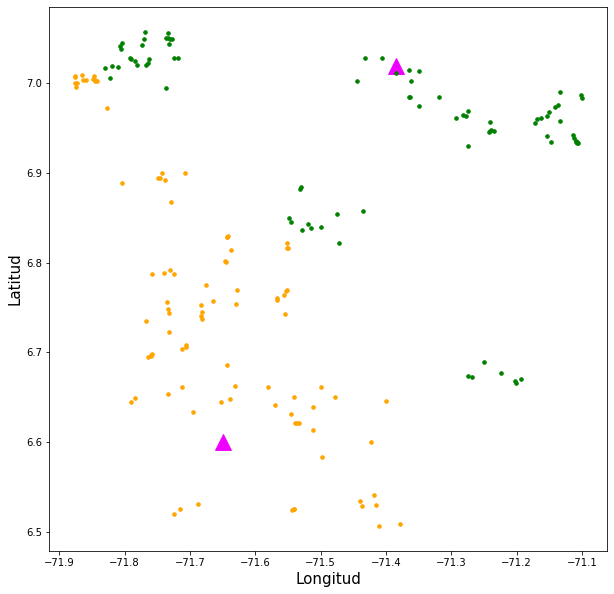

In [ ]:
import matplotlib.pyplot as plt

# Imprimir y graficar los resultados
print(f'Función Objetivo: {modeloAsignacion.getObjective().getValue()}')
print('\n')
listaFincasPlanta1 = []
for j in P:  
  cP = 0
  for i in F:
    if x[i, j].x == 1:
      cP += 1
      if j == 0:
        listaFincasPlanta1.append(i)
  print(f'Total Fincas Planta {j+1} = {cP}')
  print('\n')  


f = plt.figure()
f.set_figwidth(10)
f.set_figheight(10)

colores = ('green', 'orange')
for j in P:
  plt.scatter(centrosIniciales[j][1], centrosIniciales[j][0], color = (240/255, 0/255, 255/255), 
              marker = "^", s = 250)
  for i in F:
    if x[i, j].x == 1:
      plt.scatter(u[i][1], u[i][0], color = colores[j], marker = ".", s = 50)

plt.xlabel('Longitud', fontsize = 15)
plt.ylabel('Latitud', fontsize = 15)
plt.show()

## Implementación Partinioning Around Medioids (PAM)

In [ ]:
import pandas as pd
import random
import copy

# Función para calcular distancia (disimilaridad) entre cada finca y los medioids iniciales
def disimilaridadFincaMedioids(fincas, medioids):
  dictDist = {}
  dictAsign = {}
  for fincaAct in fincas:
    if fincaAct not in medioids:
      dictDist[fincaAct] = []
      for medioidAct in medioids:
        if haversine(fincaAct, medioidAct) != 0: # Agrega fincas sin contar el medioid actual
          dictDist[fincaAct].append(haversine(fincaAct, medioidAct))
        dictAsign[medioidAct] = [[], []]
  return dictDist, dictAsign

# Función para asignar cada finca al medioid más cercano con disponibilidad de fincas y la distancia de cada medioid a las fincas
def asignarFincasMedioid(fincas, medioids, dictDist, dictAsign):
  for fincaAct in fincas:
    if fincaAct not in medioids:
      numFincas = len(fincas)
      nMedioids = len(medioids)
      tope = (numFincas // nMedioids) - 2 # El máximo de fincas que no debería superar cada cluster
      posicionesKSirven = []
      for llave in list(dictAsign.keys()):
        if len(dictAsign[llave][0]) <= tope:
          posicionesKSirven.append(medioids.index(llave)) # Posiciones de medioids que respetan el tope
      listaDistAct = dictDist[fincaAct] # Lista de distancias de la finca a cada medioid
      if len(posicionesKSirven) > 0:
        for i in range(len(listaDistAct)):
          if i not in posicionesKSirven:
            listaDistAct[i] = 70000
      minimoAct = min(listaDistAct) # El medioid más cercano a la finca actual
      posiMedioid = listaDistAct.index(minimoAct) # Argmin de la línea anterior
      posiFinca = fincas.index(fincaAct) # Número de la finca actual
      dictAsign[medioids[posiMedioid]][0].append(minimoAct) # Agregar la distancia de la finca agregada
      dictAsign[medioids[posiMedioid]][1].append(posiFinca) # Agregar finca al medioid
  return dictAsign

# Función para eliminar un medioid en caso de que quede sin fincas
def eliminarMedioid(dictAsign):
  for medioidAct in list(dictAsign.keys()):
    listaFincasAct = dictAsign[medioidAct][1]
    if len(listaFincasAct) == 0:
      del dictAsign[medioidAct]
  return dictAsign

# Función para calcular costo total
def costoTotal(dictAsign):
  costoActual = 0
  for llave in list(dictAsign.keys()):
    costoActual += sum(dictAsign[llave][0])
  return costoActual

# Función del Swap
def swapFunction(fincas, dictAsign):
  dictAsignAct = copy.deepcopy(dictAsign)
  # Recorrer cada cluster e intercambiar una finca propia de este con cada medioid actual 
  for medioidAct in list(dictAsign.keys()):
    listaFincasAct = dictAsign[medioidAct][1] # Lista de fincas en cada cluster
    # Asegurarse que el medioid y la finca elegida no sean iguales
    termino = False
    fincaRand = listaFincasAct[random.randrange(len(listaFincasAct))] # Selección de una nueva finca como medioid
    while termino == False:
      if fincas[fincaRand] != medioidAct:
        termino = True
      else:
        fincaRand = listaFincasAct[random.randrange(len(listaFincasAct))] # Selección de una nueva finca como medioid
    dictAsignAct[fincas[fincaRand]] = dictAsignAct[medioidAct] 
    del(dictAsignAct[medioidAct]) # Reemplazar el medioid actual por una finca del cluster
    dictAsignAct[fincas[fincaRand]][1].append(fincas.index(medioidAct)) # Guardar el medioid antiguo como finca
  return dictAsignAct

# Resultados Finales

## Central 1

In [ ]:
from gurobipy import Model, GRB, quicksum
import math
# Número de Clusters por Planta Post-Cosecha
KTot = [5, 10, 15, 20]
# Capacidad de los vehículos 
QTot = [16, 28, 40, 52]

In [ ]:
f = open ('ResultadosCentral1.txt','w')
# Diccionario para guardar los valores de la función objetivo (distancia) por cada pareja (K, Q)
dictFOTotalC1 = {}
iterPAM = 0
for K1 in KTot:
  for Q in QTot:
    # PAM para Central 1
    # Lista con la ubicación de cada Finca
    n = len(listaFincasPlanta1)
    lats = list(coord_df['Latitud'])
    longs = list(coord_df['Longitud'])
    ubFincas1 = []
    for j in listaFincasPlanta1:
      ubFincas1.append((lats[j], longs[j]))

    # =================================================================== #
    #============================ FASE BUILD ============================ #
    # =================================================================== #
    # Definir cantidad de clusters y los medioids iniciales
    medioidsIniciales = [] # Asignar de forma aleatoria los K medioids a fincas existentes
    dictAsignFincasMedioids = {} # Guarda las fincas asignadas a cada medioid
    listaRand = random.sample(range(n), K1)
    for aleAct in listaRand:
      medioidsIniciales.append(ubFincas1[aleAct])
    # Calcular distancia (disimilaridad) entre cada finca y los medioids iniciales
    dictDistFincasMedioids, dictAsignFincasMedioids = disimilaridadFincaMedioids(ubFincas1, medioidsIniciales)
    # Asignar cada finca al medioid más cercano y calcular el costo (distancia) total
    dictAsignFincasMedioids = asignarFincasMedioid(ubFincas1, medioidsIniciales, dictDistFincasMedioids, dictAsignFincasMedioids)
    # Si un medioid se queda sin fincas se elimina
    dictAsignFincasMedioids = eliminarMedioid(dictAsignFincasMedioids)
    # Calcular el costo total inicial de asignación
    mejorCosto = costoTotal(dictAsignFincasMedioids)
    mejorDictDist = copy.deepcopy(dictDistFincasMedioids)
    mejorDictAsign = copy.deepcopy(dictAsignFincasMedioids)


    # =================================================================== #
    # ============================ FASE SWAP ============================ #
    # =================================================================== #

    iterMax = 1000
    i = 0

    while i < iterMax:

      # Seleccionar k puntos no-medioids, convertirlos en medioids y devolver los anteriores a fincas corrientes
      dictAsignFincasMedioidsAct = swapFunction(ubFincas1, mejorDictAsign)
      # Calcular distancia (disimilaridad) entre cada finca y los medioids actuales
      medioidsActuales = list(dictAsignFincasMedioidsAct.keys())
      dictDistFincasMedioids,  dictAsignFincasMedioids = disimilaridadFincaMedioids(ubFincas1, medioidsActuales)
      # Asignar cada finca al medioid más cercano y calcular el costo (distancia) total
      dictAsignFincasMedioids = asignarFincasMedioid(ubFincas1, medioidsActuales, dictDistFincasMedioids, dictAsignFincasMedioids)
      # Si un medioid se queda sin fincas se elimina
      dictAsignFincasMedioids = eliminarMedioid(dictAsignFincasMedioids)
      # Calcular el costo total actual de asignación
      costoActual = costoTotal(dictAsignFincasMedioids)
      if costoActual < mejorCosto:
        mejorCosto = costoActual
        mejorDictDist = copy.deepcopy(dictDistFincasMedioids)
        mejorDictAsign = copy.deepcopy(dictAsignFincasMedioids)
      i += 1 

    mejorDictAsign1 = copy.deepcopy(mejorDictAsign)
    iterPAM += 1
    print(f'Acabó PAM iteración {iterPAM}')
    f.write(f'Acabó PAM iteración {iterPAM}')
    f.write(f'\n')

    # Guardar fincas por cada cluster asociado a la planta 1
    listaFincasClusterP1 = []
    for llave in list(mejorDictAsign1.keys()):
      listaFincasClusterP1.append(mejorDictAsign1[llave][1] + [ubFincas1.index(llave)])

    # CVRP Para Central 1
    vFOClustersPlanta1 = []
    nCamionesClustersPlanta1 = []
    arcosSoluTot = []
    ubFincasTot = []
    a = 0
    print(f'Valores F.O por cada Cluster de la iteración {iterPAM}:')
    f.write(f'Valores F.O por cada Cluster de la iteración {iterPAM}:')
    f.write(f'\n')
    for lali in listaFincasClusterP1:
      
      # Conjuntos
      n = len(lali)
      N = [i for i in range(1, n + 1)] # Número de clientes
      V = [0] + N # Número de nodos en la red (incluyendo el centro post cosecha)
      A = [(i, j) for i in V for j in V if i != j] # Arcos en la red

      # Parámetros
      # Matriz de distancia:
      lats = list(coord_df['Latitud'])
      longs = list(coord_df['Longitud'])
      ubFincas = []
      ubFincas.append(centrosIniciales[0])
      for i in lali:
        ubFincas.append((lats[i], longs[i]))
      d = {(i, j):float(haversine(ubFincas[i], ubFincas[j])) for (i, j) in A}
      # Producción de las fincas
      produc = list(produccion['Producción'])
      p = []
      p.append(produc[0])
      for i in lali:
        p.append(produc[i])

      # Número de vehículos
      K = math.ceil((sum(p)/Q))

      # Crear el modelo
      modeloRuteo = Model('CVRP')
      modeloRuteo.setParam("OutputFlag",0)

      # Variables de decisión
      x = modeloRuteo.addVars(A, vtype=GRB.BINARY, name = 'x') # Si el arco (i, j) debe tomar valor
      u = modeloRuteo.addVars(N, vtype=GRB.CONTINUOUS, name = 'u') # Variable continua para eliminar los subtours

      # Restricciones
      # Sólo puede existir un arco entrante hacia cada una de las fincas
      modeloRuteo.addConstrs(quicksum(x[i, j] for i in V if i != j) == 1 for j in N)
      # Sólo puede existir un arco saliente desde cada una de las fincas
      modeloRuteo.addConstrs(quicksum(x[i, j] for j in V if j != i) == 1 for i in N)
      # Sólo puede salir un número de vehículos K de la planta post cosecha
      modeloRuteo.addConstr(quicksum(x[0, j] for j in N) == K)
      # Sólo puede llegar un número de vehículos K hacia la planta post cosecha
      modeloRuteo.addConstr(quicksum(x[i, 0] for i in N) == K)
      # Eliminar soubtours
      modeloRuteo.addConstrs((x[i, j] == 1) >> (u[i] + p[j] == u[j]) for (i, j) in A if i != 0 and j != 0)
      # Límites de las variables u
      modeloRuteo.addConstrs(u[i] >= p[i] for i in N)
      modeloRuteo.addConstrs(u[i] <= Q for i in N)

      # Función Objetivo
      modeloRuteo.modelSense = GRB.MINIMIZE
      modeloRuteo.setObjective(quicksum(x[i, j]*d[i, j] for (i, j) in A))

      modeloRuteo.Params.MIPGap = 0.1
      modeloRuteo.Params.TimeLimit = 20  # seconds
      modeloRuteo.optimize()
      #modeloRuteo.computeIIS()
      #modeloRuteo.write("model.ilp")

      # Guardar valor de la función objetivo
      try:
        vFOClustersPlanta1.append(round(modeloRuteo.getObjective().getValue(), 2))
        print(f'\t FO cluster {a}: {round(modeloRuteo.getObjective().getValue(), 2)},  Número de Vehículos: {K}')
        f.write(f'\t FO cluster {a}: {round(modeloRuteo.getObjective().getValue(), 2)},  Número de Vehículos: {K}')
        f.write(f'\n')
        a += 1
        # Guardar las rutas creadas, las ubicaciones y los camiones
        arcosSolu = []
        for (i, j) in A:
          if x[i, j].x > 0.9:
            arcosSolu.append((i, j))
        arcosSoluTot.append(arcosSolu)
        ubFincasTot.append(ubFincas)
        nCamionesClustersPlanta1.append(K)
      except:
        print(f'\t FO cluster {a}: Modelo Infactible')
        f.write(f'\t FO cluster {a}: Modelo Infactible')
        f.write(f'\n')
        vFOClustersPlanta1 = 'Infactible'
        arcosSoluTot = []
        ubFincasTot = []
        nCamionesClustersPlanta1 = [0]
        a += 1

    # Resultados CVRP Central 1
    dictFOTotalC1[K1, Q] = [vFOClustersPlanta1, max(nCamionesClustersPlanta1), arcosSoluTot, ubFincasTot]
    print(f'Número de Clusters: {K1}, \t Capacidad Q: {Q}')
    f.write(f'Número de Clusters: {K1}, \t Capacidad Q: {Q}')
    f.write('\n')
    try:
      print(dictFOTotalC1[K1, Q][0], round(sum(dictFOTotalC1[K1, Q][0]), 2))
      print('\n')
      f.write(f'{dictFOTotalC1[K1, Q][0]}, {round(sum(dictFOTotalC1[K1, Q][0]), 2)}')
      f.write('\n')
      f.write('\n')
    except:
      print(dictFOTotalC1[K1, Q][0])
      print('\n')
      f.write(f'{dictFOTotalC1[K1, Q][0]}')
      f.write('\n')
      f.write('\n')

for llave in list(dictFOTotalC1.keys()):
  try:
    f.write(f'{dictFOTotalC1[llave][1]}\t{sum(dictFOTotalC1[llave][0])}')
    f.write('\n')
  except:
    f.write(f'{dictFOTotalC1[llave][1]}\t{dictFOTotalC1[llave][0]}')
    f.write('\n')
f.close()


Acabó PAM iteración 1
Valores F.O por cada Cluster de la iteración 1:
	 FO cluster 0: 851.85,  Número de Vehículos: 8
	 FO cluster 1: 505.99,  Número de Vehículos: 6
	 FO cluster 2: 683.7,  Número de Vehículos: 8
	 FO cluster 3: 805.65,  Número de Vehículos: 7
	 FO cluster 4: 633.52,  Número de Vehículos: 7
Número de Clusters: 5, 	 Capacidad Q: 16
[851.85, 505.99, 683.7, 805.65, 633.52] 3480.71


Acabó PAM iteración 2
Valores F.O por cada Cluster de la iteración 2:
	 FO cluster 0: 498.76,  Número de Vehículos: 4
	 FO cluster 1: 329.33,  Número de Vehículos: 4
	 FO cluster 2: 381.66,  Número de Vehículos: 4
	 FO cluster 3: 523.01,  Número de Vehículos: 5
	 FO cluster 4: 437.34,  Número de Vehículos: 5
Número de Clusters: 5, 	 Capacidad Q: 28
[498.76, 329.33, 381.66, 523.01, 437.34] 2170.1


Acabó PAM iteración 3
Valores F.O por cada Cluster de la iteración 3:
	 FO cluster 0: 398.14,  Número de Vehículos: 3
	 FO cluster 1: 251.35,  Número de Vehículos: 3
	 FO cluster 2: 292.32,  Número d